In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
from dataloader import make_dataloader
from model import lineageVI
import scvelo as scv

def train_regime1(model, loader, optimizer, device, epochs):
    # Regime1: train encoder and gene_decoder only; freeze velocity_decoder
    # Freeze velocity_decoder parameters
    for param in model.velocity_decoder.parameters():
        param.requires_grad = False
    # Unfreeze encoder and gene_decoder
    for group in (model.encoder, model.gene_decoder):
        for param in group.parameters():
            param.requires_grad = True

    model.first_regime = True
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for x, idx, x_neigh in loader:
            x = x.to(device)
            x_neigh = x_neigh.to(device)
            recon, v_pred, v_gp, mean, logvar = model(x)
            loss_recon = model.reconstruction_loss(recon, x)
            loss_kl = model.kl_divergence(mean, logvar)
            loss = loss_recon + 1e-5 * loss_kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        print(f"[Regime1] Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}")

def compute_latent(model, loader, device):
    """
    Compute latent embeddings for all cells via DataLoader.
    Ensures correct mapping even if loader is shuffled.
    """
    model.eval()
    # number of cells
    n_cells = loader.dataset.adata.n_obs
    latent_list = []
    idx_all = []

    with torch.no_grad():
        for x, idx, x_neigh in loader:
            x = x.to(device)
            z, _, _ = model.encoder(x)
            latent_list.append(z.cpu())
            idx_all.extend(idx.numpy().tolist())

    # concatenate and reorder
    z_concat = torch.cat(latent_list, dim=0)
    latent_dim = z_concat.size(1)
    z_all = torch.zeros((n_cells, latent_dim), dtype=z_concat.dtype)
    z_all[idx_all] = z_concat
    return z_all.numpy()


def train_regime2(model, loader, optimizer, device, epochs):
    # Regime2: train only velocity_decoder; freeze encoder and gene_decoder
    # Freeze encoder and gene_decoder parameters
    for group in (model.encoder, model.gene_decoder):
        for param in group.parameters():
            param.requires_grad = False
    # Unfreeze velocity_decoder
    for param in model.velocity_decoder.parameters():
        param.requires_grad = True

    model.first_regime = False
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for x, idx, x_neigh, z, z_neigh in loader:
            x, x_neigh, z, z_neigh = [t.to(device) for t in (x, x_neigh, z, z_neigh)]
            _, v_pred, v_gp, _, _ = model(x)
            xz = torch.cat([x, z], dim=1)
            xz_neigh = torch.cat([x_neigh, z_neigh], dim=2)
            v_comb = torch.cat([v_pred, v_gp], dim=1)
            loss_vel = model.velocity_loss(v_comb, xz, xz_neigh)

            #loss_vel = model.velocity_loss(v_pred, x, x_neigh)

            optimizer.zero_grad()
            loss_vel.backward()
            optimizer.step()
            running_loss += loss_vel.item() * x.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        print(f"[Regime2] Epoch {epoch}/{epochs} - Velocity Loss: {epoch_loss:.4f}")

def annotate_adata(model, loader, adata, device,
                  unspliced_key: str = 'unspliced',
                  spliced_key: str = 'spliced'):
    """
    After training, use a DataLoader (first_regime=False) to annotate AnnData:
      - reconstructed unspliced & spliced expression
      - unspliced & spliced velocity
      - gene-program velocity (velocity_gp)
    """
    model.eval()
    n_cells = adata.n_obs
    # dimensions
    u = adata.layers[unspliced_key]
    G = u.shape[1] if not hasattr(u, 'shape') else u.shape[1]
    # placeholder arrays
    recon_all = np.zeros((n_cells, G*2), dtype=np.float32)
    vel_all   = np.zeros((n_cells, G*2), dtype=np.float32)
    # we will infer gp_dim from first batch
    gp_dim = None

    with torch.no_grad():
        for x, idx, x_neigh, z, z_neigh in loader:
            x = x.to(device)
            recon_batch, vel_batch, gp_batch, _, _ = model(x)
            recon_np = recon_batch.cpu().numpy()
            vel_np   = vel_batch.cpu().numpy()
            gp_np    = gp_batch.cpu().numpy()
            batch_idx = idx.numpy()
            recon_all[batch_idx] = recon_np
            vel_all[batch_idx]   = vel_np
            if gp_dim is None:
                gp_dim = gp_np.shape[1]
                gp_all = np.zeros((n_cells, gp_dim), dtype=np.float32)
            gp_all[batch_idx] = gp_np

    # split expression / spliced parts
    recon_u = recon_all[:, :G]
    recon_s = recon_all[:, G:]
    vel_u   = vel_all[:, :G]
    vel_s   = vel_all[:, G:]

    # store in AnnData
    adata.layers['recon_u']    = recon_u
    adata.layers['recon']      = recon_s
    adata.layers['velocity_u'] = vel_u
    adata.layers['velocity']   = vel_s
    adata.obsm['velocity_gp']          = gp_all

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load preprocessed AnnData
adata = sc.read_h5ad("/home/lgolinelli/git/lineageVI/input_processed_anndata/pancreas_PCA_on_Ms_200moments.h5ad")

# hyperparameters
K = 10
batch_size = 1024
lr = 1e-3
epochs1 = 50
epochs2 = 50
n_hidden = 128
mask_key = 'I'
gene_prior = True
seeds = [0,1,2]

# initialize model and optimizer
model = lineageVI(
    adata,
    n_hidden=n_hidden,
    mask_key=mask_key,
    gene_prior=gene_prior,
    seed=seeds[0],
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Regime 1
loader1 = make_dataloader(adata, first_regime=True, K=K, batch_size=batch_size, shuffle=True, seed=seeds[1])
train_regime1(model, loader1, optimizer, device, epochs1)

# compute and store latent embeddings
z_emb = compute_latent(model, loader1, device)
adata.obsm['z'] = z_emb

# Regime 2
loader2 = make_dataloader(adata, first_regime=False, K=K, batch_size=batch_size, shuffle=False, seed=seeds[2])
train_regime2(model, loader2, optimizer, device, epochs2)

# annotate via DataLoader2
annotate_adata(model, loader2, adata, device)
#adata.write("adata_with_velocity.h5ad")

# save model weights
#torch.save(model.state_dict(), "vae_velocity_model.pt")

[Regime1] Epoch 1/50 - Loss: 20.6778
[Regime1] Epoch 2/50 - Loss: 20.6258
[Regime1] Epoch 3/50 - Loss: 20.5692
[Regime1] Epoch 4/50 - Loss: 20.4986
[Regime1] Epoch 5/50 - Loss: 20.4113
[Regime1] Epoch 6/50 - Loss: 20.3097
[Regime1] Epoch 7/50 - Loss: 20.1946
[Regime1] Epoch 8/50 - Loss: 20.0682
[Regime1] Epoch 9/50 - Loss: 19.9300
[Regime1] Epoch 10/50 - Loss: 19.7835
[Regime1] Epoch 11/50 - Loss: 19.6269
[Regime1] Epoch 12/50 - Loss: 19.4624
[Regime1] Epoch 13/50 - Loss: 19.2900
[Regime1] Epoch 14/50 - Loss: 19.1122
[Regime1] Epoch 15/50 - Loss: 18.9283
[Regime1] Epoch 16/50 - Loss: 18.7399
[Regime1] Epoch 17/50 - Loss: 18.5484
[Regime1] Epoch 18/50 - Loss: 18.3541
[Regime1] Epoch 19/50 - Loss: 18.1581
[Regime1] Epoch 20/50 - Loss: 17.9631
[Regime1] Epoch 21/50 - Loss: 17.7649
[Regime1] Epoch 22/50 - Loss: 17.5661
[Regime1] Epoch 23/50 - Loss: 17.3682
[Regime1] Epoch 24/50 - Loss: 17.1708
[Regime1] Epoch 25/50 - Loss: 16.9738
[Regime1] Epoch 26/50 - Loss: 16.7772
[Regime1] Epoch 27/50

In [3]:
adata.layers['velocity'] *=-1
adata.obsm['velocity_gp'] *=-1

computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


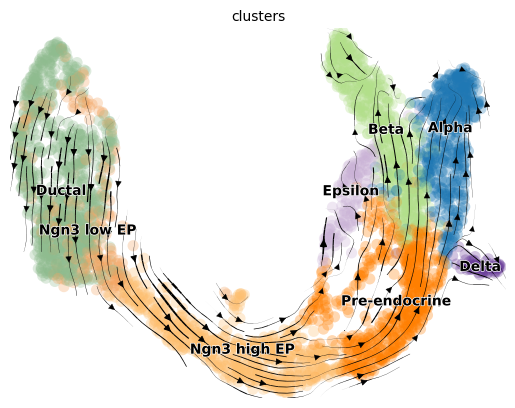

In [4]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


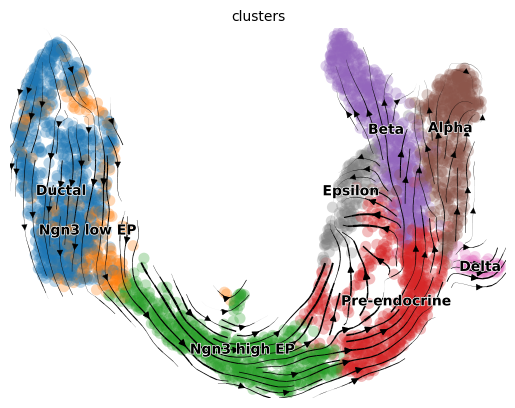

In [5]:
adata_gp = sc.AnnData(X=adata.obsm['z'])

adata_gp.obs = adata.obs.copy()
adata_gp.var_names = adata.uns['terms']
adata_gp.layers['velocity'] = adata.obsm['velocity_gp']
adata_gp.layers['spliced'] = adata.obsm['z']
adata_gp.obsm['X_umap'] = adata.obsm['X_umap']

sc.pp.neighbors(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


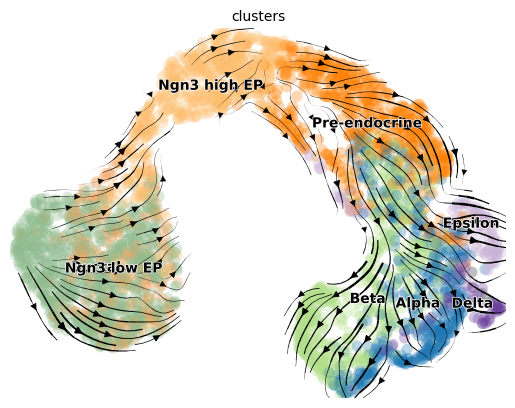

In [6]:
sc.pp.neighbors(adata, use_rep='z')
sc.tl.umap(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


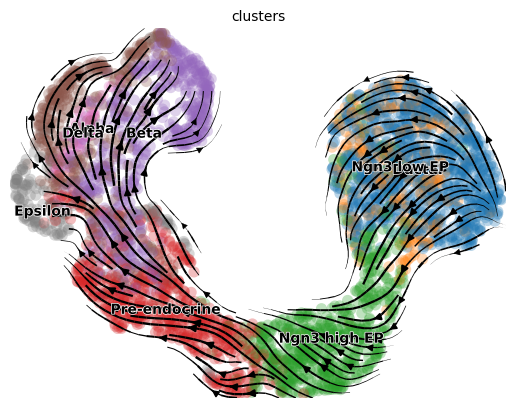

In [7]:
sc.pp.neighbors(adata_gp)
sc.tl.umap(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [8]:
adata_gp.layers['velocity'].shape

(3696, 647)

In [9]:
adata_gp.layers['velocity'].mean(0)[np.argsort(adata_gp.layers['velocity'].mean(0))[::-1]]

array([ 2.45352936e+00,  2.19881892e+00,  2.04810333e+00,  1.83106041e+00,
        1.65747941e+00,  1.60234702e+00,  1.40675616e+00,  1.36354876e+00,
        1.32318461e+00,  1.31494188e+00,  1.29484010e+00,  1.29438162e+00,
        1.25325167e+00,  1.23795795e+00,  1.20509243e+00,  1.20031250e+00,
        1.18019211e+00,  1.18012261e+00,  1.17552841e+00,  1.16020715e+00,
        1.13604033e+00,  1.11919260e+00,  1.06469023e+00,  1.04929209e+00,
        1.03259170e+00,  1.03167701e+00,  9.62830305e-01,  9.57160056e-01,
        9.50951040e-01,  9.40872669e-01,  9.13801134e-01,  8.85502338e-01,
        8.84056151e-01,  8.27543437e-01,  8.02872896e-01,  7.22849905e-01,
        7.21170425e-01,  7.07603931e-01,  7.01753199e-01,  6.62931621e-01,
        6.60396576e-01,  6.37690306e-01,  6.16569042e-01,  6.16562545e-01,
        6.02356970e-01,  5.91244102e-01,  5.91053605e-01,  5.86634278e-01,
        5.79247534e-01,  5.79174340e-01,  5.77921629e-01,  5.73820353e-01,
        5.63944161e-01,  

In [10]:
adata_gp.var_names[np.argsort(adata_gp.layers['velocity'].mean(0))[::-1]]

Index(['FETAL_PANCREAS_ISLET_ENDOCRINE', 'FETAL_INTESTINE_CHROMAFFIN_CEL',
       'REGULATION_OF_BETA_CELL_DEVELO', 'BRAIN_HCP_WITH_H3K27ME3',
       'RB1_TARGETS_UP', 'NEGATIVE_REGULATION_OF_CELL_DE',
       'NPC_HCP_WITH_H3K4ME2', 'FETAL_SPLEEN_AFP_ALB_POSITIVE_',
       'UNSTIM_VS_48H_MBOVIS_BCG_STIM_', 'WT_VS_SGK1_KO_TH17_DIFFERENTIA',
       ...
       'FETAL_LIVER_HEPATOBLASTS', '88', 'FETAL_LUNG_NEUROENDOCRINE_CELL',
       'FETAL_STOMACH_NEUROENDOCRINE_C', 'MAIN_FETAL_ISLET_ENDOCRINE_CEL',
       'INSULIN_SECRETION', 'MATURITY_ONSET_DIABETES_OF_THE',
       'FETAL_CEREBELLUM_VASCULAR_ENDO', 'UNTREATED_VS_IL2_TREATED_CD8_T',
       'LUPUS_VS_HEALTHY_DONOR_BCELL_D'],
      dtype='object', length=647)